<p align="center">
  <a>
    <img src="./figures/logo-hi-paris-retina.png" alt="Logo" width="280" height="180">
  </a>

  <h3 align="center">Data Science Bootcamp</h3>
</p>

Authors : Yann Berthelot, Florian Bettini, Laure-Amélie Colin

In this lab, we briefly recall some machine learning basics, and we are interested in a problem of building a regression model using machine learning algorithms.

## What is a machine learning model:

The Building a machine learning model can be summed up in finding a link function $f$
 ($Y=f(X) + \epsilon$) which is most often the
result of error minimization : <p style="text-align: center;">$\sum_i E(Y_i,f(X_i))$</p> where
$(X_i,Y_i)$ is a list of pairs (features, target).

**Objective:** 
- Train the model from a dataset and assess its ability to generalize on unseen data
- Understand the explanatory factors of our target
    
**Method:**
- Separate the target variable from the features
- separate the data into three samples (train / validation / test)
- train the model (on the train set) and evaluate its performance (on the test set).


## Feature Engineering
Feature engineering is the process by which knowledge of data is used to construct explanatory variables, features, that can be used to train a predictive model. Engineering and selecting the correct features for a model will not only significantly improve its predictive power, but will also offer the flexibility to use less complex models that are faster to run and more easily understood.

### Feature Engineering from Datetime
The timestamp in itself is not a useful feature, but we can extract from it some features. Ex: day of the week.

### Feature Engineering from transformation 
Feature transformations can include aggregating, combining transforming attributes to create new features. Useful and relevant features will depend on the problem at hand but averages, sums, log or ratios can better expose trends to a model.

We can also transform a numerical feature into a categorical feature by cutting it into classes. This can be interesting to avoid the impact of outliers or to reduce the variance of the output variable.

##### Example: 

```python
# log transformation
data['var_transformed'] = data['var'].apply(np.log)

# polynomial transformation
data['var_transformed'] = data['var']**2
```

### Data Encoding
Some algorithms can work with categorical data directly. This means that categorical data must be converted to a numerical form. 
To Convert Categorical Data to Numerical Data, this involves two steps :

- Integer  (ordinal or cardinal)
- One-Hot Encoding

##### Example:
Use [pd.get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) for OneHotEncoding

```python
# list of columns to encode using One-Hot-Encoding
columns_to_encode = ["var1", "var2"]

# encode those columns
encoded_data = pd.get_dummies(data[columns_to_encode], columns=columns_to_encode)

# add encoded columns to the data
data = pd.concat([data, encoded_data], axis=1)
```


Objective of this lab
======

Use feature engineering to add new relevant features for your predictions.

<p align="center">
  <a>
    <img src="./figures/UpToYou.png" alt="Logo" width="200" height="280">
  </a>
</p>

#### Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from model import train_model_for_feature_engineering

#### Step 1. Cleaning, Feature Engineering and Encoding

In [2]:
def feature_engineering_external_data(external_data: pd.DataFrame) -> pd.DataFrame:
    '''
    Compute new features based on the original features from the external_data dataset.

    Input:
    external_data (pd.DataFrame): input DataFrame

    Output:
    (pd.DataFrame): DataFrame with additional features
    '''
    external_data = external_data.groupby(["STATE_CODE", "Date"]).agg({
        "tmax":["mean", "max", "min"],
        "tmin":["mean", "max", "min"],
        "prcp":["mean", "max", "min"],
        "Median Age":"mean",
        "Total Population": "mean",
        "Average Household Size": "mean"
    }).reset_index()
    kpis = [
        "tmax_mean", "tmax_max", "tmax_min", "tmin_mean",
        "tmin_max", "tmin_min", "prcp_mean", "prcp_max",
        "prcp_min", "Median Age_mean", "Total Population_mean",
        "Average Household Size_mean"
    ]
    external_data.columns = ["STATE_CODE", "Date", *kpis]

    external_data["delta_t"] = external_data["tmax_mean"] - external_data["tmin_mean"]

    return external_data


def feature_engineering_fires(fires: pd.DataFrame, fires_days: pd.DataFrame) -> pd.DataFrame:
    '''
    Compute new features based on the original features from the fires dataset.

    Input:
    external_data (pd.DataFrame): input DataFrame

    Output:
    (pd.DataFrame): DataFrame with additional features
    '''
    # count the number of fire per day and state
    fires_count = fires.groupby(["DISCOVERY_DATE", "STATE"]).agg({"FOD_ID":"count"}).reset_index()
    fires_count.columns = ["DISCOVERY_DATE", "STATE", "FIRE_COUNT"]
    combinations = fires_days[["DISCOVERY_DATE", "STATE"]].copy()
    fires_count = pd.merge(combinations, fires_count, how="left", on=["DISCOVERY_DATE", "STATE"])
    fires_count["FIRE_COUNT"] = fires_count["FIRE_COUNT"].fillna(0).astype("int")

    # number of fires at t - 1 year, on a 1 month window, 1 week window and 1 day window
    fires_count["FIRE_COUNT_Y1_M1"] = fires_count.groupby(["STATE"])[["FIRE_COUNT"]].transform(lambda x: x.shift(365).rolling(30).sum())
    fires_count["FIRE_COUNT_Y1_W1"] = fires_count.groupby(["STATE"])[["FIRE_COUNT"]].transform(lambda x: x.shift(365).rolling(7).sum())
    fires_count["FIRE_COUNT_Y1_D1"] = fires_count.groupby(["STATE"])[["FIRE_COUNT"]].transform(lambda x: x.shift(365))
    return fires_count


def feature_engineering_all(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Encode categorical variables and fill na values
    '''
    # add dates
    df["DISCOVERY_DOW"] = df["DISCOVERY_DATE"].dt.dayofweek
    df["DISCOVERY_MONTH"] = df["DISCOVERY_DATE"].dt.month
    df["DISCOVERY_DAY"] = df["DISCOVERY_DATE"].dt.day
    # drop unused columns
    df.drop(columns=["Date", "STATE_CODE", "FIRE_COUNT"], inplace=True)
    # fillna kpis from external data
    cols_fillna = [
        "tmax_mean", "tmax_max", "tmax_min", "tmin_mean",
        "tmin_max", "tmin_min", "prcp_mean",
        "prcp_max", "prcp_min", "delta_t",
        "Median Age_mean", "Total Population_mean",
        "Average Household Size_mean", "FIRE_COUNT_Y1_M1",
        "FIRE_COUNT_Y1_W1", "FIRE_COUNT_Y1_D1"
    ]
    for c in cols_fillna:
        df[c] = df[c].fillna(df[c].mean())

    # encode state
    data_cat = pd.get_dummies(df["STATE"])
    df = pd.concat([df, data_cat], axis=1)

    return df

In [3]:
# train_set
fires_days = pd.read_csv("./data/1_raw/fires/fires_days_train.csv", parse_dates=["DISCOVERY_DATE"])

# external_data
external_data = pd.read_csv("./data/2_clean/external_data.csv", parse_dates=["Date"])
external_data = feature_engineering_external_data(external_data)

# fires data
fires = pd.read_csv("./data/2_clean/fires.csv", parse_dates=["DISCOVERY_DATE"])
fires_count = feature_engineering_fires(fires, fires_days)

# merge
fires_days = pd.merge(fires_days, external_data, how="left", left_on=["STATE", "DISCOVERY_DATE"], right_on=["STATE_CODE", "Date"])
fires_days = pd.merge(fires_days, fires_count, how="left", on=["STATE", "DISCOVERY_DATE"])

# cleaning and encoding
fires_days = feature_engineering_all(fires_days)

# save to csv format
fires_days.to_csv("./data/3_input_model/input_model.csv", index=False)

## "Simple" evaluation of your feature engineering
Here you can train a random forest using the features you created as some way to benchmark different feature engineering. Actual model selection and tuning will be done during the next lab.

In [4]:
data = fires_days
min_year_pred = "2015-01-01"
target_col = "FIRE"
ratio = 0.75

# find max number of occurrence per day
max_occ_day = data.groupby("DISCOVERY_DATE").agg({"STATE":"count"}).max().values[0]

# split train and prediction datasets
X_pred = data[data["DISCOVERY_DATE"] >= min_year_pred].set_index(["DISCOVERY_DATE", "STATE"]).copy()
X_pred.drop(columns=["FIRE"], inplace=True) # get features for predictions
data = data[data["DISCOVERY_DATE"] < min_year_pred].copy() # get train data (features and target values)
data[target_col] = data[target_col].astype("int")


Step 1
f1-micro: 0.7547593958552862
f1-macro: 0.7447418127408003
f1-weighted: 0.7530933510039765
accuracy: 0.7547593958552863

Step 2
f1-micro: 0.7889708465050932
f1-macro: 0.7781125126495037
f1-weighted: 0.7900053019375087
accuracy: 0.7889708465050931

Step 3
f1-micro: 0.7784334387074114
f1-macro: 0.7675290638960003
f1-weighted: 0.7818784147263262
accuracy: 0.7784334387074113
f1-micro: 0.8029634300126104
f1-macro: 0.7830198675242197
f1-weighted: 0.802002544332927
accuracy: 0.8029634300126104


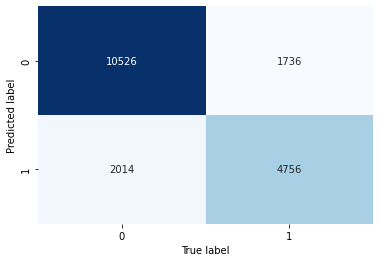

/Users/yberthel/Documents/bootcamp-hiparis2022/model.py:196: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


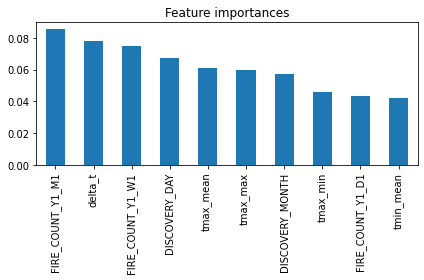

In [5]:
train_model_for_feature_engineering(data, target_col, ratio=ratio)